<a href="https://colab.research.google.com/github/JaradAng/tensorflow_training/blob/main/transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#bringing in the helper functions to save time
!wget https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py

--2022-12-16 20:15:08--  https://raw.githubusercontent.com/JaradAng/tensorflow_training/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2022-12-16 20:15:08 (93.7 MB/s) - ‘helper_functions.py’ saved [10234/10234]



In [2]:
#importing them to notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train'

test_dir = '101_food_classes_10_percent/test'

--2022-12-16 20:15:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   229MB/s    in 7.1s    

2022-12-16 20:15:19 (219 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
!nvidia-smi

Fri Dec 16 20:15:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#walking through directories
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_fo

In [7]:
import tensorflow as tf
#setting up data inputs
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from tensorflow.python.ops.variables import model_variables
#building model from transfer learning for 10 percent of 101 food classes
1. create modelcheckpoint callbacl
2. create data augmentation layer
3. build headless (no top layer) functional eff.net b0 backbone model and create output layer
4. compile the model_variables
5. feature extract for 5 full epochs and validate of 15% of test data to speed it up

In [8]:
#create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [13]:
#create data augmentation layer to incorporate
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#set up data aug
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
    #preprocessing.Rescaling(1/255.) Not needing with eff net but if use resnet it is needed
])

In [15]:
#setting up base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

 #set up model architecture
inputs = layers.Input(shape=(224,224,3), name = 'input_layer')
x=data_augmentation(inputs) #augments the images
x = base_model(x, training=False) #puts base model in inference mode
x = layers.GlobalAveragePooling2D(name='global_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x)
model = tf.keras.Model(inputs, outputs)





In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_layer (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [17]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

In [19]:
history_0 = model.fit(train_data_all_10_percent,
                      epochs = 5,
                      steps_per_epoch = len(train_data_all_10_percent),
                      validation_data = test_data,
                      validation_steps= int(0.15 * len(test_data)),
                      callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 93s 337ms/step - loss: 3.3702 - accuracy: 0.2774 - val_loss: 2.5271 - val_accuracy: 0.4401
Epoch 2/5
237/237 [==============================] - 66s 278ms/step - loss: 2.1911 - accuracy: 0.5039 - val_loss: 2.0240 - val_accuracy: 0.5114
Epoch 3/5
237/237 [==============================] - 60s 251ms/step - loss: 1.8132 - accuracy: 0.5686 - val_loss: 1.8957 - val_accuracy: 0.5249
Epoch 4/5
237/237 [==============================] - 57s 240ms/step - loss: 1.6064 - accuracy: 0.6086 - val_loss: 1.8290 - val_accuracy: 0.5328
Epoch 5/5
237/237 [==============================] - 54s 228ms/step - loss: 1.4304 - accuracy: 0.6474 - val_loss: 1.7716 - val_accuracy: 0.5416


In [21]:
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 1.5848 - accuracy: 0.5817


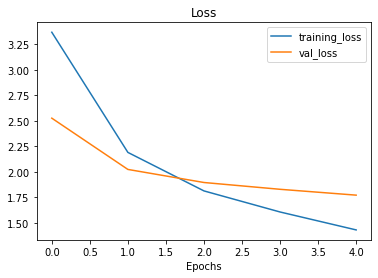

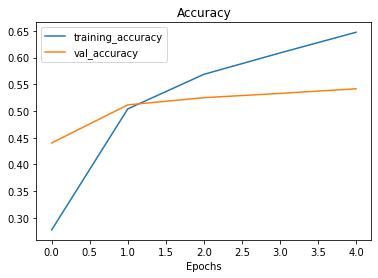

In [22]:
plot_loss_curves(history_0)

In [23]:
# the above model looks to be overfitting when the val loss goes above the training loss

### Fine tune a few layers

In [29]:
#unfreeze the layers in base model
base_model.trainable = True

#refreeze all but last five
for layer in base_model.layers[:-5]:
  layer.trainable = False 

In [30]:
#recompile after fine tuning
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [31]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 tf.math.truediv_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [33]:
#fine tuning the model
fine_tune_epochs = 10 #total number of epochs after original 5 

history_0_fine_tuned = model.fit(train_data_all_10_percent,
                                 epochs = fine_tune_epochs,
                                 validation_data = test_data,
                                 validation_steps = (0.15 * len(test_data)),
                                 initial_epoch = history_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 61s 228ms/step - loss: 1.4963 - accuracy: 0.5982 - val_loss: 1.7193 - val_accuracy: 0.5394
Epoch 6/10
237/237 [==============================] - 49s 204ms/step - loss: 1.0726 - accuracy: 0.7114 - val_loss: 1.7538 - val_accuracy: 0.5460
Epoch 7/10
237/237 [==============================] - 48s 199ms/step - loss: 0.8347 - accuracy: 0.7595 - val_loss: 1.9444 - val_accuracy: 0.5257
Epoch 8/10
237/237 [==============================] - 46s 191ms/step - loss: 0.6387 - accuracy: 0.8219 - val_loss: 1.9641 - val_accuracy: 0.5312
Epoch 9/10
237/237 [==============================] - 46s 191ms/step - loss: 0.5130 - accuracy: 0.8531 - val_loss: 2.0929 - val_accuracy: 0.5202
Epoch 10/10
237/237 [==============================] - 45s 186ms/step - loss: 0.4358 - accuracy: 0.8737 - val_loss: 1.9405 - val_accuracy: 0.5565


In [34]:
#evaluate on all test data
fine_tuned_model_0 = model.evaluate(test_data)

790/790 [==============================] - 60s 76ms/step - loss: 1.9308 - accuracy: 0.5639


In [37]:
#compare the histories
# compare_histories(original_history = history_0,
#                  mew_history = history_0_fine_tuned,
#                  initial_epochs = 5)

NameError: ignored

### Saving and loading the model

In [38]:
#save the fine tuned model
model.save('/content/drive/MyDrive/101_food_class_model')

In [39]:
#load and evaluate
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/101_food_class_model')

In [40]:
#evaluate loaded model
loaded_model.evaluate(test_data)

790/790 [==============================] - 63s 77ms/step - loss: 1.9308 - accuracy: 0.5639


[1.9308151006698608, 0.563920795917511]